# UFGsim2024infufg
> Module to handle loading, preprocessing and postprocessing of the data from the simulated world for UFG's dataset
>
> Still needs proper documentation

In [ ]:
#| default_exp UFGsim2024infufg

In [ ]:
#| exports
import torch
import re
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import yaml
from pathlib import Path
import numpy as np
from lightning import LightningDataModule
from torchvision.transforms import v2
from colorcloud.behley2019iccv import SphericalProjection

introduction here

In [ ]:
#| exports
class UFGSimDataset(Dataset):
    "Load the UFGSim dataset ina pytorch Dataset object."
    def __init__(self, data_path, split='train', transform=None):
        data_path = Path(data_path)
        yaml_path = data_path/'ufg-sim.yaml'
        self.ufgsim_velodyne_path = data_path/'laser_scans'

        with open(yaml_path, 'r') as file:
            metadata = yaml.safe_load(file)

        lasers = metadata['split'][split]
        self.labels_dict = metadata['labels']

        ufgsim_velodyne_fns = []
        for laser in lasers:
            ufgsim_velodyne_fns += list(self.ufgsim_velodyne_path.rglob(f'laser{laser}/*.bin'))
  
        self.frame_ids = [fn.stem for fn in sorted(ufgsim_velodyne_fns)]
        self.frame_lasers = [fn.parts[-2] for fn in sorted(ufgsim_velodyne_fns)]

        self.learning_map = metadata['learning_map']
        max_key = sorted(self.learning_map.keys())[-1]
        self.learning_map_np = np.zeros((max_key+1,), dtype=int)
        for k, v in self.learning_map.items():
            self.learning_map_np[k] = v
        
        self.learning_map_inv = metadata['learning_map_inv']
        self.learning_map_inv_np = np.zeros((len(self.learning_map_inv),))
        for k, v in self.learning_map_inv.items():
            self.learning_map_inv_np[k] = v
        
        self.color_map_bgr = metadata['color_map']
        max_key = sorted(self.color_map_bgr.keys())[-1]
        self.color_map_rgb_np = np.zeros((max_key+1,3))
        for k,v in self.color_map_bgr.items():
            self.color_map_rgb_np[k] = np.array(v[::-1], np.float32)
        
        self.transform = transform
        self.is_test = (split == 'test')


    def learning_remap(self, remapping_rules):
        new_map_np = np.zeros_like(self.learning_map_np, dtype=int)
        max_key = sorted(remapping_rules.values())[-1]
        new_map_inv_np = np.zeros((max_key+1,), dtype=int)
        for k, v in remapping_rules.items():
            new_map_np[self.learning_map_np == k] = v
            if new_map_inv_np[v] == 0:
                new_map_inv_np[v] = self.learning_map_inv_np[k]
        self.learning_map_np = new_map_np
        self.learning_map_inv_np = new_map_inv_np
    
    def __len__(self):
        return len(self.frame_ids)

    def set_transform(self, transform):
        self.transform = transform
        
    def __getitem__(self, idx):
        frame_id = self.frame_ids[idx]
        frame_laser = self.frame_lasers[idx]

        frame_path = self.ufgsim_velodyne_path/frame_laser/(frame_id + '.bin')

        with open(frame_path, 'rb') as f:
            frame = np.fromfile(f, dtype=np.float32).reshape(-1, 4)
            x_frame = frame[:, 0]
            y_frame = frame[:, 1]
            z_frame = frame[:, 2]
            label = frame[:, 3].astype(np.uint8)

        label = self.learning_map_np[label]
        mask = label != 0

        if self.transform:
            frame, label, mask = self.transform(frame, label, mask)
        # return x_frame, y_frame, z_frame, label
        return frame, label, mask
        


The dataset files are organized as follows:
- data
  - laser_scans
      - laser0
        - pcd1.bin
        - pcd2.bin
        - ...
      - laser1
        - pcd1.bin
        - pcd2.bin
        - ...
      - ...
  - ufg-sim.yaml

Instructions of download and label description

In [ ]:
#| eval: false
data_path = '../UFGSim'
ds = UFGSimDataset(data_path)
ds[127]

(array([[-1.2693751e+01, -3.3684009e-05, -1.5585943e+00,  0.0000000e+00],
        [-1.7000994e+01, -4.5113662e-05, -1.4873919e+00,  0.0000000e+00],
        [-2.5397661e+01, -6.7394976e-05, -1.3310331e+00,  4.0000000e+00],
        ...,
        [-3.7802494e+01,  1.0031231e-04, -6.5984398e-01,  9.0000000e+00],
        [-3.7758598e+01,  1.0019583e-04,  6.5907782e-01,  9.0000000e+00],
        [-3.7734058e+01,  1.0013071e-04,  1.9775552e+00,  9.0000000e+00]],
       dtype=float32),
 array([0, 0, 1, ..., 4, 4, 4]),
 array([False, False,  True, ...,  True,  True,  True]))

In [ ]:
#| eval: false
frame, label, mask = ds[127]
frame[:,0] - frame[:,2]

array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [ ]:
#| exports
class ProjectionSimTransform(nn.Module):
    def __init__(self, projection):
        super().__init__()
        self.projection = projection
        self.W = projection.W
        self.H = projection.H

    def forward(self, frame, label, mask):
        scan_xyz = frame[:,:3]
        

        depth = np.linalg.norm(scan_xyz, 2, axis=1)

        proj_x, proj_y, outliers = self.projection.get_xy_projections(scan_xyz, depth)

        # filter outliers
        if outliers is not None:
            proj_x = proj_x[~outliers]
            proj_y = proj_y[~outliers]
            scan_xyz = scan_xyz[~outliers]
            depth = depth[~outliers]
            if label is not None:
                label = label[~outliers]
                mask = mask[~outliers]

        order = np.argsort(depth)[::-1]
        info_list = [scan_xyz, depth[..., np.newaxis]]
        if label is not None:
            info_list += [mask[..., np.newaxis]]
            info_list += [label[..., np.newaxis]]

        scan_info = np.concatenate(info_list, axis=-1)
        scan_info = scan_info[order]
        proj_y = proj_y[order]
        proj_x = proj_x[order]


        projections_img = np.zeros((self.H, self.W, 2+len(info_list)))
        projections_img[:,:,-1] -= 1
        projections_img[proj_y, proj_x] = scan_info

        if label is not None:
            frame_img = projections_img[:,:,:-2]
            label_img = projections_img[:,:,-1].astype(int)
            mask_img = projections_img[:,:,-2].astype(bool)
            mask_img = mask_img & (label_img > -1)

        else:
            frame_img = projections_img
            label_img = None
            mask_img = projections_img[:,:,-1] >= 0

        return frame_img, label_img, mask_img

In [ ]:
#| eval: false
proj = SphericalProjection(fov_up_deg=3., fov_down_deg=-25., W=440, H=16)
tfms = ProjectionSimTransform(proj)
ds.set_transform(tfms)
frame_img, label_img, mask_img = ds[127]

In [ ]:
#| eval: false
frame_img[:2], frame_img.shape, frame_img.dtype

(array([[[-3.77493401e+01, -1.00171274e-04,  1.97835624e+00,
           3.78011475e+01],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00],
         ...,
         [-3.62925797e+01,  1.03925407e+00,  1.90279031e+00,
           3.63572845e+01],
         [-3.65888863e+01,  5.23810685e-01,  1.91773605e+00,
           3.66428528e+01],
         [-3.77340584e+01,  1.00130710e-04,  1.97755516e+00,
           3.77858429e+01]],
 
        [[-3.77706947e+01, -1.00227931e-04,  6.59288943e-01,
           3.77764473e+01],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00],
         ...,
         [-3.63273849e+01,  1.04025066e+00,  6.34355843e-01,
           3.63478127e+01],
         [-3.66113434e+01,  5.24132192e-01,  6.39117897e-01,
           3.66206

In [ ]:
#| eval: false
label_img[:2], label_img.shape, label_img.dtype, set(label_img.flatten())

(array([[ 4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1,  9,  9,  9,  9,  9,  9,  9,
          9,  9,  9, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  6, -1, -1,  6,  6, -1, -1, -1, -1, -1,
          6,  6,  6,  6,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3, -1, -1, -1, -1, -1,  7,  7,  7,  7,  5,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  5,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7

In [ ]:
#| eval: false
mask_img[:2], mask_img.shape, mask_img.dtype

(array([[ True, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True, False,
         False,  True,  True, False, False, False, False, False,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,

In [ ]:
#| exports
class ProjectionSimVizTransform(nn.Module):
    def __init__(self, color_map_rgb_np):
        super().__init__()
        self.color_map_rgb_np = color_map_rgb_np

    def scale(self, img, min_value, max_value):
        img = img.clip(min_value, max_value)
        return (255.*(img - min_value)/(max_value - min_value)).astype(int)

    def forward(self, frame_img, label_img, mask_img):
        normalized_frame_img = None
        if frame_img is not None:
            x = self.scale(frame_img[:,:,0], -100., 100.)
            y = self.scale(frame_img[:,:,1], -100., 100.)
            z = self.scale(frame_img[:,:,2], -31., 5.)
            d = self.scale(frame_img[:,:,3], 0., 100.)
            normalized_frame_img = np.stack((x, y, z, d), axis=-1)
            normalized_frame_img[mask_img == False] *= 0

        colored_label_img = None
        if label_img is not None:
            colored_label_img = np.zeros(label_img.shape + (3,))
            colored_label_img[mask_img] = self.color_map_rgb_np[label_img[mask_img]]
            colored_label_img = colored_label_img.astype(int)

        return normalized_frame_img, colored_label_img, mask_img

In [ ]:
#| eval: false
from matplotlib import pyplot as plt

In [ ]:
#| eval: false
def plot_projections(img, label):
    fig, axs = plt.subplots(5, 1, figsize=(20,10), layout='compressed')
    for i, (ax, title) in enumerate(zip(axs, ['x', 'y', 'z', 'd', 'label'])):
        if i < 4:
            ax.imshow(img[:,:,i])
        else:
            ax.imshow(label)
        ax.set_title(title)
        ax.axis('off')

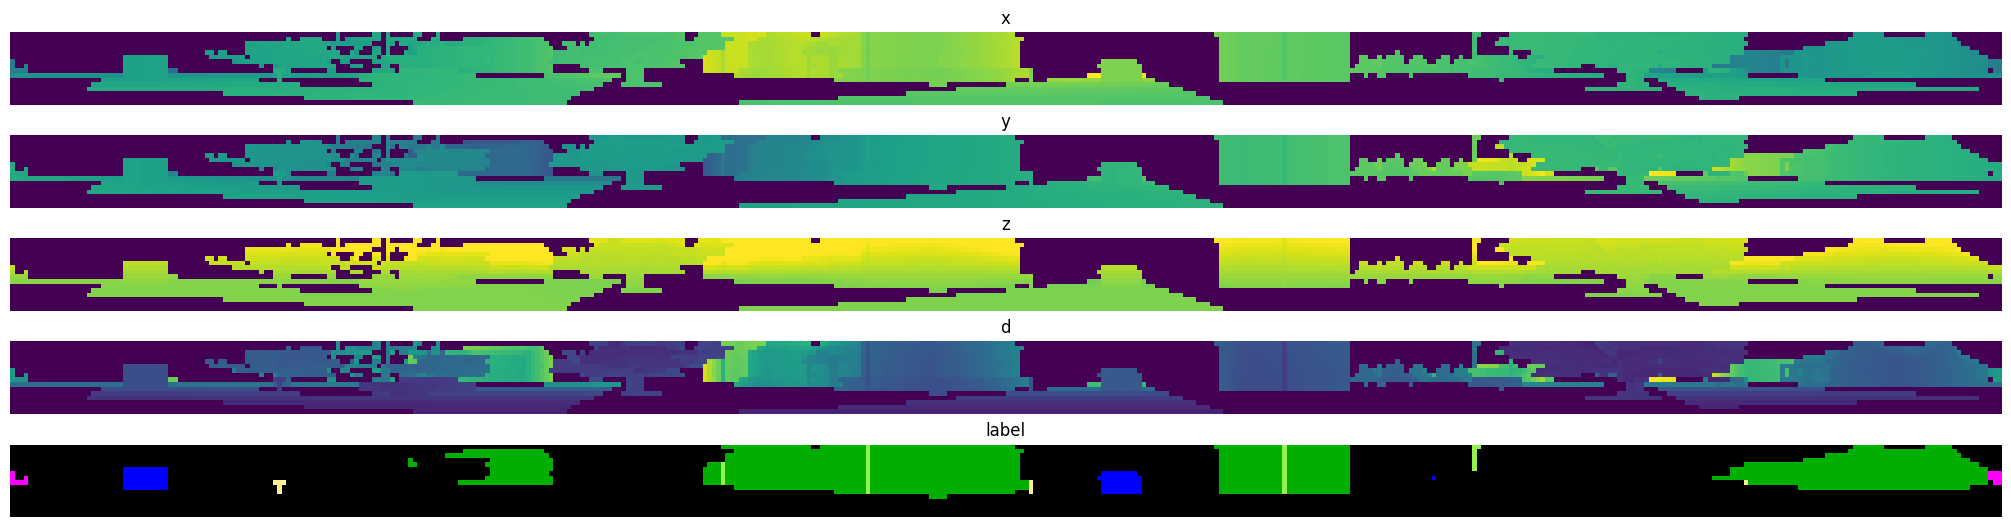

In [ ]:
#| eval: false
proj = SphericalProjection(fov_up_deg=15., fov_down_deg=-15., W=440, H=16) 
tfms = v2.Compose([
    ProjectionSimTransform(proj),
    ProjectionSimVizTransform(ds.color_map_rgb_np),
])
ds.set_transform(tfms)
img, label, _ = ds[127]

plot_projections(img, label)

In [ ]:
#| eval: false
%timeit img, label, _ = ds[0]

4.44 ms ± 199 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
#| exports
class ProjectionToTensorTransformSim(nn.Module):
    "Pytorch transform that converts the projections from np.array to torch.tensor. It also changes the frame image format from (H, W, C) to (C, H, W)."
    def forward(self, frame_img, label_img, mask_img):
        frame_img = np.transpose(frame_img, (2, 0, 1))
        frame_img = torch.from_numpy(frame_img).float()
        label_img = torch.from_numpy(label_img)
        mask_img = torch.from_numpy(mask_img)
        return frame_img, label_img, mask_img

In [ ]:
#| eval: false
proj = SphericalProjection(fov_up_deg=15., fov_down_deg=-15., W=440, H=16)
tfms = v2.Compose([
    ProjectionSimTransform(proj),
    ProjectionToTensorTransformSim(),
])
ds.set_transform(tfms)
img, label, mask = ds[127]
print(img.shape, img.type())
print(label.shape, label.type())
print(mask.shape, mask.type())

torch.Size([4, 16, 440]) torch.FloatTensor
torch.Size([16, 440]) torch.LongTensor
torch.Size([16, 440]) torch.BoolTensor


In [ ]:
#| eval: false
bs = 10
dl = DataLoader(ds, bs, num_workers=0)
for batch in dl:
    img, label, mask = batch
    print(f"Shape of img \t [N, C, H, W]: \t {img.shape}")
    print(f"Shape of label \t [N, H, W]: \t {label.shape}")
    print(f"Shape of mask \t [N, H, W]: \t {mask.shape}")
    break

Shape of img 	 [N, C, H, W]: 	 torch.Size([10, 4, 16, 440])
Shape of label 	 [N, H, W]: 	 torch.Size([10, 16, 440])
Shape of mask 	 [N, H, W]: 	 torch.Size([10, 16, 440])


In [ ]:
#| eval: false
from tqdm.auto import tqdm

/home/joao/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#| eval: false
for batch in tqdm(dl):
    img, label, mask = batch

100%|███████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 10.84it/s]


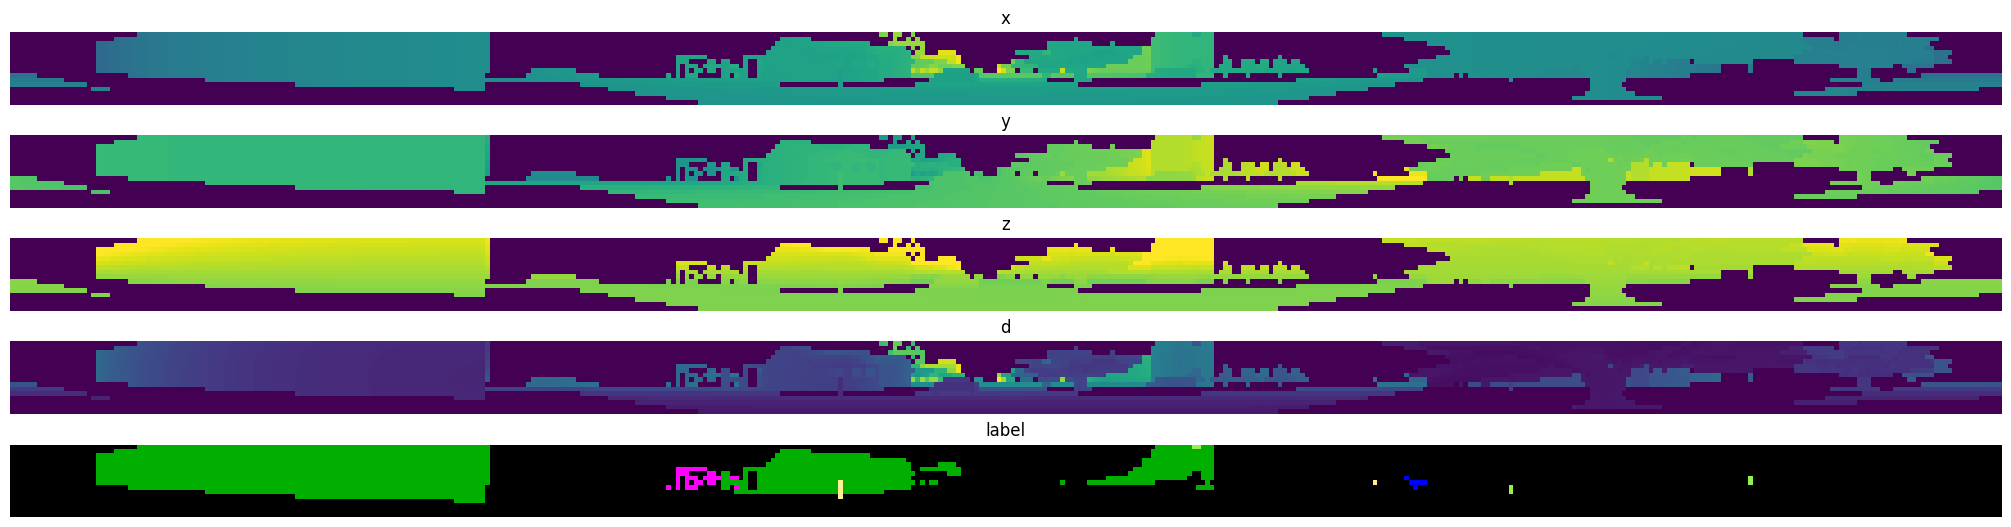

In [ ]:
#| eval: false
ds = UFGSimDataset(data_path)
proj = SphericalProjection(fov_up_deg=15., fov_down_deg=-15., W=440, H=16)
tfm = ProjectionSimTransform(proj)
ds.set_transform(tfm)

bs = 1000
dl = DataLoader(ds, bs)
img, label, mask = next(iter(dl))

idx = ((label <= 0).sum(axis=1) > 60).sum(axis=1).argmax()

tfms = v2.Compose([
    ProjectionSimTransform(proj),
    ProjectionSimVizTransform(ds.color_map_rgb_np),
])
ds.set_transform(tfms)

i, l, _ = ds[idx]
plot_projections(i, l)

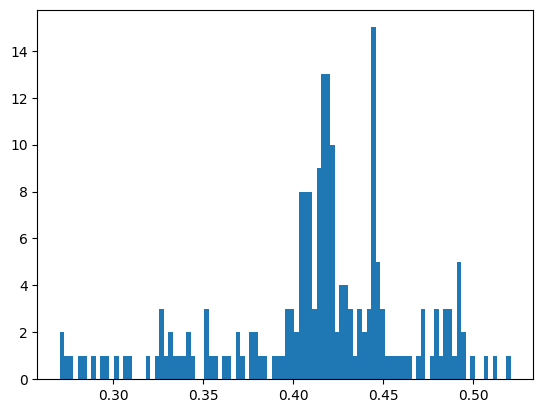

In [ ]:
#| eval: false
ds.set_transform(tfm)

bs = 1000
dl = DataLoader(ds, bs, shuffle=True)
img, label, mask = next(iter(dl))

sparsity = (label <= 0).sum(axis=(1,2))/label[0].numel()
plt.hist(sparsity, bins=100);

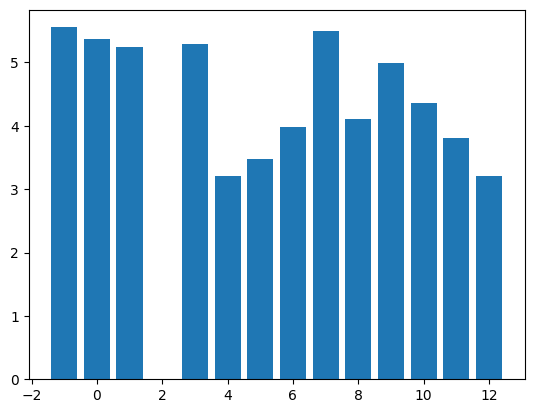

In [ ]:
#| eval: false
l = label.flatten()
values, counts = np.unique(l, return_counts=True)
plt.bar(values, np.log10(counts));

In [ ]:
#| exports
class SemanticSegmentationSimLDM(LightningDataModule):
    "Lightning DataModule to facilitate reproducibility of experiments."
    def __init__(self, 
                 proj_style='spherical',
                 proj_kargs={'W': 440, 'H': 16},
                 train_batch_size=8, 
                 eval_batch_size=16,
                 num_workers=8
                ):
        super().__init__()

        proj_class = {
        'unfold': UnfoldingProjection,
        'spherical': SphericalProjection
        }
        assert proj_style in proj_class.keys()
        self.proj = proj_class[proj_style](**proj_kargs)
        self.remapping_rules = remapping_rules
        self.train_batch_size = train_batch_size
        self.eval_batch_size = eval_batch_size
        self.num_workers = num_workers
    
    def setup(self, stage: str):
        data_path = '/workspace/data'
        tfms = v2.Compose([
            ProjectionSimTransform(self.proj),
            ProjectionToTensorTransformSim(),
        ])
        split = stage
        if stage == 'fit':
            split = 'train'
        ds = UFGSimDataset(data_path, split, transform=tfms)
        if not hasattr(self, 'viz_tfm'):
            self.viz_tfm = ProjectionSimVizTransform(ds.color_map_rgb_np)
        
        if stage == "fit":
            self.ds_train = ds
            self.ds_val = UFGSimDataset(data_path, 'valid', tfms)
        
        if stage == "test":
            self.ds_test = ds
        if stage == "predict":
            self.ds_predict = ds
            

    def train_dataloader(self):
        return DataLoader(self.ds_train, batch_size=self.train_batch_size, num_workers=self.num_workers, shuffle=True, drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=self.eval_batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.ds_test, batch_size=self.eval_batch_size, num_workers=self.num_workers)

    def predict_dataloader(self):
        return DataLoader(self.ds_predict, batch_size=self.eval_batch_size, num_workers=self.num_workers)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()